In [6]:
%matplotlib inline

eta=0.5
rho=-0.3
alpha=0.25
F=1

In [7]:
import math
def iv(T, K):
    etaT=eta/math.sqrt(T)
    l=etaT/alpha
    logK=math.log(K/F)
    return alpha*(1+1/2*rho*l*logK+1/12*(2-3*rho**2)*(l*logK)**2)

In [8]:
import numpy as np
Ts=np.arange(1,13)*4*7/365.0
Ks=np.arange(0.7, 1.45, 0.05)

ivs=np.zeros((len(Ts),len(Ks)))
for i in range(len(Ts)):
    for j in range(len(Ks)):
        ivs[i,j]=iv(Ts[i], Ks[j])

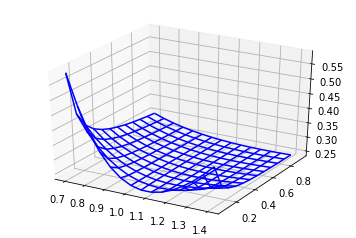

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
X, Y = np.meshgrid(Ks, Ts)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, ivs, color='blue')
plt.savefig('ivs.pdf')

In [8]:
from scipy.stats import norm

def compute_black_scholes(T_surf, K_surf, ivs_surf):
    d1 = (np.log(F/K_surf) + 0.5 * np.square(ivs_surf) * T_surf)/(ivs_surf*np.sqrt(T_surf))
    d2 = d1 - ivs_surf * np.sqrt(T_surf)
    
    C = F * norm.cdf(d1) - K_surf * norm.cdf(d2)
    P = K_surf * norm.cdf(-d2) - F * norm.cdf(-d1)
    vega = np.square(T_surf) * norm.pdf(d1)
    
    return C, P, vega

n=100000
nT=len(Ts)
Ks=np.arange(-2, 2.5, 0.5)
nK=len(Ks)

x_lv_ext = np.array([Ks*0.2*math.sqrt(Ts[i]) for i in range(nT)]) 
K_ext = np.exp(x_lv_ext)
T_ext = np.array([Ts for _ in range(nK)]).T

ivs=np.zeros((len(Ts),len(Ks)))
for i in range(len(Ts)):
    for j in range(len(Ks)):
        ivs[i,j]=iv(T_ext[i, j], K_ext[i, j])

calls_mkt, puts_mkt, vega_mkt = compute_black_scholes(T_ext, K_ext, ivs)
lv = np.copy(ivs)

#a = np.ones([len(Ts), 1])
#F = np.ones([len(Ts), 1])
divTimes = np.arange(0.25, 20, 0.5)
divAmount = 0.025
lambdaDiv = 0.5
F = np.array([1.0]*3 + [1.0-divAmount]*6 + [1.0-2*divAmount]*3)
a = np.zeros([len(Ts), 1])
for i in range(len(Ts)):
    a[i] = divAmount*np.sum(np.exp(-lambdaDiv*divTimes[Ts[i]<divTimes]))

In [14]:
dt=7.0/365.0
sqrtDt=math.sqrt(dt)
nTw = nT*4

import tensorflow as tf

class LocalVol:
    
    def __init__(self):
        
        with tf.device("/gpu:0"):

            self.lv_t=tf.Variable(lv, dtype=tf.float32)
            self.Ts_t=tf.constant(Ts, dtype=tf.float32)
            self.x_lv_ext_t=tf.constant(x_lv_ext, dtype=tf.float32)

            W = tf.random_normal((nTw, n), dtype=tf.float32)

            def cond(i, _1, _2):
                return i < nTw

            def body(i, R, ta):
                j = tf.floordiv(i, 4)

                dx_lv = 0.5*0.2*tf.sqrt(self.Ts_t[j])
                indices_x_d = tf.minimum(tf.maximum(0, tf.cast(R / dx_lv, dtype=tf.int32) + len(Ks)//2), len(Ks)-1)
                indices_x_u = tf.minimum(indices_x_d+1, len(Ks)-1)
                sigma_interp = (tf.gather(self.x_lv_ext_t[j,:], indices_x_u)-R) / dx_lv * tf.gather(self.lv_t[j, :], indices_x_d) + \
                               (R-tf.gather(self.x_lv_ext_t[j,:], indices_x_d)) / dx_lv * tf.gather(self.lv_t[j, :], indices_x_u)

                sigma_t = tf.where(R<=self.x_lv_ext_t[j, 0],
                                   self.lv_t[j, 0]*np.ones((1,n), dtype=np.float32),
                                   tf.where(R>=self.x_lv_ext_t[j, -1],
                                            self.lv_t[j, -1]*np.ones((1,n), dtype=np.float32),
                                            sigma_interp))
                R = R + sqrtDt*sigma_t*W[i, :] - 0.5*np.square(sigma_t)*dt

                ta = ta.write(i, R)
                return i+1, R, ta

            ta = tf.TensorArray(dtype=tf.float32, size=nTw)
            _0, _1, ta = tf.while_loop(cond, body, [0, tf.zeros([1, n]), ta])

            C = tf.squeeze(ta.stack())
            X = tf.exp(C[3::4, :])
            S = a + (F - tf.exp(lambdaDiv*Ts))*X
            S = S + lambdaDiv * a * tf.cumsum(np.exp(lambdaDiv*Ts)*X, axis=0)

            S_all = tf.expand_dims(S, 2)
            S_all = tf.tile(S_all, (1, 1, nK))

            K_all = tf.constant(K_ext, shape=(nT, nK), dtype=tf.float32)
            K_all = tf.expand_dims(K_all, 1)
            K_all = tf.tile(K_all, (1, n, 1))

            self.calls_mod = tf.reduce_mean(tf.maximum(0.0, S_all - K_all), axis=1)
            self.puts_mod = tf.reduce_mean(tf.maximum(0.0, K_all - S_all), axis=1)

            err_call = tf.reduce_sum(tf.boolean_mask(tf.square((self.calls_mod-calls_mkt)/vega_mkt), K_ext >= F))
            err_put = tf.reduce_sum(tf.boolean_mask(tf.square((self.puts_mod-puts_mkt)/vega_mkt), K_ext < F))
            err = err_call + err_put

            optim = tf.train.AdamOptimizer(learning_rate=0.0025)
            self.training_op = optim.minimize(err)
            self.init = tf.global_variables_initializer()
        
            
    def calibrate(self):
        with tf.Session() as sess:
            sess.run(self.init)
            for i in range(200):
                print(i)
                #sess.run(self.puts_mod)
                sess.run(self.training_op)
            return sess.run([self.puts_mod, self.calls_mod, self.lv_t])
        
lv_mod = LocalVol()
p, c, lv_calibrated = lv_mod.calibrate()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [ ]:
np.where(K_ext < F,p-puts_mkt,c-calls_mkt)

In [ ]:
np.where(K_ext < F,p-puts_mkt,c-calls_mkt)/vega_mkt

In [1]:
import tensorflow as tf

with tf.device("/gpu:0"):
    a = tf.constant(2, dtype=tf.float32)
    b = tf.constant(3, dtype=tf.float32)
    c = a * b


In [2]:
print(tf.__version__)


1.10.0


In [3]:
with tf.Session() as sess:
    cc = sess.run(c)
print(cc)

6.0


In [ ]:
hello = tf.constant('Hello, TensorFlow!')


In [ ]:
sess = tf.Session()


In [ ]:
print(sess.run(c))


In [21]:
divTimes = np.arange(0.25, 20, 0.5)
divAmount = 0.025
lambdaDiv = 0.5
F = np.array([1.0]*3 + [1.0-divAmount]*6 + [1.0-2*divAmount]*3)
a = np.zeros([len(Ts), 1])
for i in range(len(Ts)):
    a[i] = divAmount*np.sum(np.exp(-lambdaDiv*divTimes[Ts[i]<divTimes]))

In [9]:
a = np.zeros([len(Ts), 1])
divTimes = np.arange(0.25, 20, 0.5)

In [13]:
np.where(Ts[4]<divTimes)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39]),)

In [18]:
Ts[10]<divTimes

array([False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True], dtype=bool)

In [17]:
Ts[8]

0.69041095890410964

In [23]:
q=np.exp(lambdaDiv*Ts)
q.shape

(12,)